## Transient Simulations 
*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [2]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv
import seaborn as sns
from pyDOE import *
import random
#additional analysis tools
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)


moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws = "D:/mfoutput/transientDrawdown"

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Discretization and other inputs

In [5]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

width = 100
dx= width #width of grid cells in x direction 
dy= width #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('../base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties - These get overwritten in the run code cell
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 10e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (25.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 


rip_rows_forced = (22.0, 29.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

Rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
Rip_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 


## Recharge
rech=5e-5  #m/d


rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


print(ztop[25])

[100.   99.   98.   97.   96.   95.   94.   93.   92.   91.   90.   89.
  88.   87.   86.   85.   84.   83.   82.   81.   80.   79.   78.   77.
  76.   75.9  75.8  75.7  75.6  75.5  75.4  75.3  75.2  75.1  75.   74.9
  74.8  74.7  74.6  74.5  74.4  74.3  74.2  74.1  74.   73.9  73.8  73.7
  73.6  73.5]


In [6]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 2
nper = int(sp_peryr*sim_years + 1)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array - actually we are doing it every 6 days to save computation time
nstp=perlen/6 # Slghtly less than weekly 
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", nstp)

#Irrigation well

#Aqua Seca Well well
pumping = -450 #m3/day 
SteadyPump = -2000 #might want to increase the seasonal pumping
well_row =   19 #12
well_col =   32 #14
well_loc = (2,well_row, well_col)
well = [2,well_row, well_col, pumping] 

wel_spd =  {0: [2,well_row, well_col, 0]}
well_val = np.tile([1,0],sim_years+1)
for p in range(1, nper):   
    #pumping = 0
    wel_spd[p] =  [2,well_row, well_col, pumping*well_val[p]]

#Steady Pumping rate 
wel_spdst =  {0: [2,well_row, well_col, 0]}
well_val = np.tile([1,1],sim_years+1)
for p in range(1, nper):   
    #pumping = 0
    wel_spdst[p] =  [2,well_row, well_col, SteadyPump*well_val[p]]
    
print(wel_spdst)


Period lengths [ 10 180 180 180 180]
Number of Steps [ 1 30 30 30 30]
{0: [2, 19, 32, 0], 1: [2, 19, 32, -2000], 2: [2, 19, 32, -2000], 3: [2, 19, 32, -2000], 4: [2, 19, 32, -2000]}


### Layering

In [7]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array

## Made some changes to the thickness
bot_elev = 0. #0
mid_elev = 40. #40
top_elev = 45. #45

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [8]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0

## Right Boundary condition
h_right = 68.5 #was 70

H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,0,49]=0
ibound[:,49,49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#new bottom no flow zone constriction
ibound[:,1,19:]=0
ibound[:,2,25:]=0
ibound[:,3,30:]=0
ibound[:,4,33:]=0
ibound[:,5,36:]=0
ibound[:,6,39:]=0
ibound[:,7,41:]=0
ibound[:,8,43:]=0
ibound[:,9,45:]=0
ibound[:,10,46:]=0
ibound[:,11,47:]=0
ibound[:,12,48:]=0

ibound[:,48,19:]=0
ibound[:,47,25:]=0
ibound[:,46,30:]=0
ibound[:,45,33:]=0
ibound[:,44,36:]=0
ibound[:,43,39:]=0
ibound[:,42,41:]=0
ibound[:,41,43:]=0
ibound[:,40,45:]=0
ibound[:,39,46:]=0
ibound[:,38,47:]=0
ibound[:,37,48:]=0

#np.savetxt("ibound_lyr1.txt", ibound[0])

## Stream with SFR2 Package

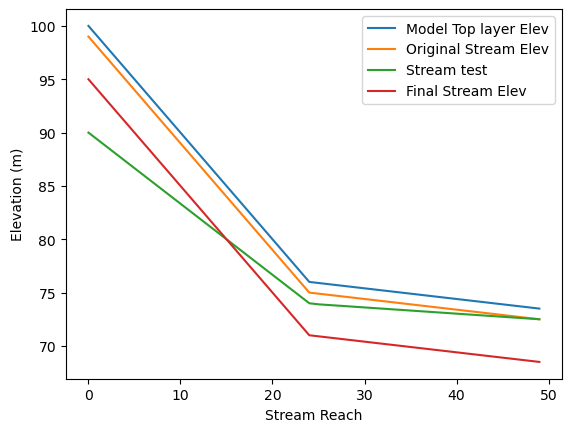

In [9]:
#SFR package inputs
ztop = np.genfromtxt('../base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

reach = np.recarray((nrow,), dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8'),('strtop', '<f4')])

reach[:][:] = 0.0 # zero it out
#reach['k'][:] = 0 #testing
reach['i'][:] = ncol/2   #set it to the middle row
reach['j'][:] = [i for i in range(nrow)] #all columns in the middle row
reach['iseg'][:] = 1 #segment number - we only have 1 so all cells - segment number starts with 1!
#reach['iseg'][25:] = 2
reach['ireach'][:50] = [i for i in range(1,51)] #number the 50 reaches - starts with 1!
#reach['ireach'][25:] = [i for i in range(1,26)]
reach['rchlen'][:] = dx * 1.2 #using a moderate sinuosity of 1.2 from Rosgen 
reach['strtop'][:] = ztop[25]-5 #Sets the stream elevation to below the top of the top layer cells 
#print(ztop)

#Segment Data - 1 segment with 50 reaches
dtype = flopy.modflow.ModflowSfr2.get_default_segment_dtype() #get the correct datatypes for the segments
indices = ['nseg','width1','width2','icalc','roughch','flow','outseg','iupseg','hcond1','hcond2','thickm1','thickm2','etsw','pptsw','elevup','elevdn']

seg_data = np.recarray((1,), dtype[indices])
seg_data[:] = 0
seg_data['width1'] = 5 #Upstream width
seg_data['width2'] = 5 #downstream width
seg_data['icalc'] = 1 #Stream depth calculated every stress period - assumes wide rectangular channel - uses Manning's equation
seg_data['nseg'] = 1 #segment number
seg_data['roughch'] = 0.045 #Manning's n 
seg_data['flow'] = 100#initial inflow at first reach in segment
seg_data['hcond1'] = 0.0001 #K - also set in the run cell as it is one of the parameters that is varied
seg_data['hcond2'] = 0.0001 
seg_data['thickm1'] = 2  #Stream bed thickness
seg_data['thickm2'] = 2  
seg_data['elevup'] = reach['strtop'][0]   #elevation at start added reach strtop for transeint was 100 and 70 for eleveldn
seg_data['elevdn'] = reach['strtop'][-1]
seg_data['etsw'] = 0  #Stream channel ET
seg_data['pptsw'] = 0 #Stream channel precip

segment_data = seg_data

nstrm = -len(reach)  # number of reaches - negative for transient!
nss = 1 #len(seg_data[0])  # number of segments
nsfrpar = 0  # number of parameters (not supported)
nparseg = 0
const = 86400  # constant for manning's equation, units of cms
dleak = 0.0001  # closure tolerance for stream stage computation
ipakcb = 53  # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81  # flag for writing SFR output to text file
dataset_5 = {0:[nss, 0, 0]}  # dataset 5 (see online guide) - first one must be equal to number of segments 
numtim =  1#number of timesteps to compute for routing
for i in range(1,nper):
    dataset_5[i] = [0, 0, 0] #one for every stress period, first number must be less than number of segments (except first stress period) (for some reason)


irtflg = 1 #flag for routng with kinematic wave, if so desired, other params need to be set

strbtm_elevs = np.linspace(ztop[25][25]-2,ztop[25][-1]-1,25)
strtop_elevs = np.linspace(ztop[25][0]-10,ztop[25][24]-2,25)
streamtest=np.zeros((50,))
#streamtest = ztop[25].copy()
streamtest[:25] = strtop_elevs
streamtest[25:] = strbtm_elevs

plt.plot(ztop[25], label='Model Top layer Elev')
plt.plot(ztop[25]-1, label='Original Stream Elev')
plt.plot(streamtest, label='Stream test')
plt.plot(reach['strtop'][:], label = 'Final Stream Elev')
plt.xlabel('Stream Reach')
plt.ylabel('Elevation (m)')
plt.legend()

In [10]:
# import random
# num = 100 #number of runs - len(sampling) for all 2500 ensemble members
# leakage_array = np.zeros((num,1))

# #pull in the similations that were used in the SS decision tree, randomly sample 100 for start 
# ssList = np.loadtxt('SS_SimList.txt').astype('int').tolist()
# n = random.sample(ssList, num)
# #np.savetxt('TransSamples.txt',n)

# ntest = np.loadtxt('TransSamples.txt')
# print(ntest.astype('int'))
# print(ssList)

## create packages and run model

In [11]:
well_head_df= pd.read_pickle('../outputs/heads/WellHead_SS1000test9.pkl')
print(len(well_head_df.index.values))
sampling = np.loadtxt("ModflowParams8-1000Test4.txt")

print(sampling[well_head_df.index.values].shape)

959
(959, 8)


In [ ]:
#create model object

#load in the parameter sampling from text - so it's the same everytime
#sampling = np.loadtxt("ModflowParams8-1000Test4.txt")
n = len(sampling)#np.loadtxt('TransSamples.txt').astype('int')
error_list = []

members = well_head_df.index.values

#Using the same numbering as the steady state (so 11)
for i in members:
    #print(sampling[i])
    #modelname = "ScenarioSfr750Seasons_"+str(i)
    modelname = "ScenarioSfr1000SteadyPumpTest9_"+str(i)
    m = flopy.modflow.Modflow(modelname,model_ws = modws, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady,perlen=perlen, nstp=nstp)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    #Layer properties - lpf
    ## make horizontal K np arrays
    #Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kh[:,:,:] = 5#sampling[i][0] # assign the original value to the entire array

    ## Make a arrays for the K values
    #Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kz[:,:,:] = 5#sampling[i][0] #* sampling[i][7]                # assign the original value to the entire array
    
    #restrictive layer
    Kz[1,:,10:49] = sampling[i][0] * sampling[i][1] #* sampling[i][7]       #Replace K in the middle layer with the lower value
    Kh[1,:,10:49] = sampling[i][0] * sampling[i][1]     
    #changed to 10 for start of restrictive layer
    
    Sy = sampling[i][2]
    
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, #laywet = [1,1,1],
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    
    #Setting up ET stress periods   
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = sampling[i][4]
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = (sampling[i][4] * sampling[i][5])
    
#     ET_val=np.tile([1, 0],sim_years)
#     ET_val=np.append(sampling[i][4]/2,ET_val) #add on steady state period at beginning with 1/2 the ET 
   
#     ET = {} #ET Stress period dictionary
#     for p in range(1,nper):    #loop over stress periods
#         #print(ET_val[p])        
#         ET[p]=ET_zone*ET_val[p] 
    
#     evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #no seasonality


    #Recharge - rch
    rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]= sampling[i][3]
      
    rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object

    #SFR2 
    seg_data['hcond1'] = seg_data['hcond2'] = sampling[i][6]
    
    sfr = flopy.modflow.ModflowSfr2(
        model = m,
        nstrm=nstrm,
        nss=nss,
        const=const,
        dleak=dleak,
        ipakcb=ipakcb,
        #istcb1 = 81,
        istcb2=istcb2,
        reach_data=reach,
        segment_data=seg_data,
        #channel_geometry_data=channel_geometry_data,
        #channel_flow_data=channel_flow_data,
        dataset_5=dataset_5,
        #unit_number=15,
        irtflg = irtflg,
        numtim = numtim,#number of timesteps to compute for routing
        flwtol = 0.00003*86400,
        transroute = True
    )
    sfr.assign_layers(adjust_botms=True, pad=1.0) #I haven't figure out yet why the Transient version has issues with the channel bottom - but this fixes it by offsetting by -1 if there is an issue
    #print(sfr.reach_data)
    
    #Well - wel
   # wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd) #Seasonal pumping

    #Steady Pumping rate 
    wel_spdst =  {0: [2,well_row, well_col, 0]}
    well_val = np.tile([1,1],sim_years+1)
    for p in range(1, nper):   
        #pumping = 0
        wel_spdst[p] =  [2,well_row, well_col, SteadyPump*well_val[p]*sampling[i][7]]
        
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spdst) #steady pumping lower rate

    #Output control - OC 

    oc_spd = {}
    for kper in range(nper):
        for kstp in range(nstp[kper]):
            #print(kstp)
            oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
   # spd = {(-1, -1): [],
     #   (0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, 
                               mxiter=100, iter1=200, 
                               relax = 0.97,
                               damp = 0.7
                              )
    #chk = sfr.check()
#     wel.check()
#     pcg.check()
#     m.check()
#     oc.check()
#     evt.check()
#     rch.check()
#     lpf.check()
#     bas.check()
    #write the inputs
    #sfr.plot(key='iseg')
    m.write_input()   
    
    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=False)
    if not success:
        #raise Exception('MODFLOW did not terminate normally.')      
        print('MODFLOW did not terminate normally. Parameters saved to file')
        #save parameters        
        error_list.append(np.hstack((np.array(i),sampling[i])))

if len(error_list) > 0:
    #np.savetxt("ErrorSeasons_Sfr750.txt", error_list)
    np.savetxt("ErrorSteadyPump_Sfr1000Test9.txt", error_list)

    print(len(error_list), " models did not terminate normally.")
    #print(error_list[:,0])
    error_list = np.asarray(error_list)
    n2 = np.setdiff1d(members, error_list[:,0].astype('int'))
else:
    n2 = members
    
for k,i in enumerate(n2):
    modelname = "ScenarioSfr1000SteadyPumpTest9_"+str(i)
    sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
    df = sfrout.get_dataframe()
    #Plot of all every reaches for every time step 
    #should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
    df['Stp']= 1
    df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*30*numtim)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column
    df['simnum'] = i
    #group rows by change in Stp and grab the last Stress period 
    Stpdf = df.groupby('Stp').tail(n=50) #groups tthe dataframe by the Stress period then grabs the last 50 rows (reaches) of the stress period representing the last timestep
    Stpdf.reset_index(drop=True, inplace = True)
   # print(Stpdf)
    if k == 0:
        savedf = Stpdf
    else:
        savedf = savedf.append(Stpdf) #apparently appending a dataframe is improper so this takes a minute

print(len(savedf))
savedf.to_csv('TransOutputStpSteadyPumpTest9.csv')

FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_0.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:38:46

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:

 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Wa

 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Wa

 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Wa

 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Wa

 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Wa

 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:39:47
 Elapsed run time: 10.594 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:39:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:

 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Wa

 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Wa

 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Wa

 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Wa

 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Wa

 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:40:46
 Elapsed run time: 11.307 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_11.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:40:46

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step

 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Wa

 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Wa

 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Wa

 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Wa

 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Wa

 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:41:48
 Elapsed run time: 10.386 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_16.nam 
 Run start date and time (yyyy/mm/d

 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Wa

 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Wa

 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Wa

 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:42:43
 Elapsed run time:  4.288 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITER

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Wa

 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Wa

 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Wa

 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Wa

 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Wa

 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Wa

 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Wa

 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Wa

 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Wa

 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Wa

 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Wa

 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Wa

 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Wa

 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Wa

 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Wa

 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Wa

 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Wa

 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Wa

 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Wa

 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Wa

 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Wa

 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Wa

 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Wa

 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Wa

 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Wa

 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Wa

 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Wa

 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Wa

 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Wa

 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Wa

 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Wa

 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Wa

 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Wa

 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Wa

 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:53:50
 Elapsed run time: 12.283 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_83.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:53:50

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step

 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Wa

 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Wa

 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Wa

 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Wa

 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Wa

 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Wa

 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Wa

 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Wa

FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_93.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:55:24

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period

 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Wa

 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Wa

 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Wa

 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Wa

 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Wa

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:56:27
 Elapsed run time: 12.461 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_98.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:56:27

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step

 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Wa

 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Wa

 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Wa

 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Wa

 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Wa

 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:57:29
 Elapsed run time: 11.786 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_103.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:57:29

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time ste

 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Wa

 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Wa

 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Wa

 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Wa

 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Wa

 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 21:58:33
 Elapsed run time: 13.192 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME fi

 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Wa

 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Wa

 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Wa

 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Wa

 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Wa

 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Wa

 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Wa

 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Wa

 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:01:12
 Elapsed run time: 13.573 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_122.nam 
 Run start date and time (yyyy/mm/

 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Wa

 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Wa

 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Wa

 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Wa

 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:02:15
 Elapsed run time: 13.356 Seconds

  Normal termination of simulation
FloPy 

 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Wa

 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Wa

 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Wa

 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:03:1

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Wa

 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Wa

 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Wa

 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Wa

 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Wa

 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Wa

 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Wa

 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Wa

 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Wa

 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Wa

 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Wa

FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_153.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:07:03

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress perio

 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Wa

 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Wa

 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Wa

 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Wa

 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Wa

 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:08:06
 Elapsed run time: 14.127 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_159.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:08:07

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time ste

 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    17    Ground-Wa

 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Wa

 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Wa

 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Wa

 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Wa

 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:09:08
 Elapsed run time: 12.040 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfr1000SteadyPumpTest9_164.nam 
 Run start date and time (yyyy/mm/

 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    16    Ground-Wa

 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Wa

 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Wa

 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Wa

 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:10:08
 Elapsed run time: 12.566 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME fi

 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Wa

 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    24    Ground-Wa

 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Wa

 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Wa

 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Wa

 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:11:07
 Elapsed run time: 11.845 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
               

 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Wa

 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Wa

 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Wa

 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Wa

 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    16    Ground-Wa

 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:12:04
 Elapsed run time: 10.198 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLO

 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Wa

 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Wa

 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    30    Ground-Wa

 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Wa

 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    15    Ground-Wa

 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:13:00
 Elapsed run time:  9.406 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/

 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Wa

 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Wa

 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    26    Ground-Wa

 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Wa

 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Wa

 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Wa

 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Wa

 Solving:  Stress period:     2    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Wa

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Wa

 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Wa

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Wa

 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    24    Ground-Wa

 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:15:5

 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Wa

 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Wa

 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Wa

 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Wa

 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Wa

 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Wa

 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Wa

 Solving:  Stress period:     2    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Wa

 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    13    Ground-Wa

 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/17 22:17:5

 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

## Looking at the SFR Output

,index,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,...,stage,depth,width,Cond,gradient,kstpkper,k,i,j,Stp
0,0,1,26,1,1,1,100.000,0.0000,100.000,0.0,...,94.7402,0.005213,5.0,0.0,0.000000,"(0, 0)",0,25,0,1
1,1,1,26,2,1,2,100.000,100.0000,0.000,0.0,...,94.2062,0.001173,5.0,4849.0,0.263200,"(0, 0)",0,25,1,1
2,2,1,26,3,1,3,0.000,0.0000,0.000,0.0,...,93.6750,0.000000,5.0,4849.0,0.104600,"(0, 0)",0,25,2,1
3,3,1,26,4,1,4,0.000,-29.4040,29.404,0.0,...,93.1467,0.001652,5.0,4849.0,-0.003032,"(0, 0)",0,25,3,1
4,4,1,26,5,1,5,29.404,-197.4500,226.850,0.0,...,92.6210,0.006050,5.0,4849.0,-0.020360,"(0, 0)",0,25,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,6405,1,26,46,1,46,7113.300,-26.1790,7139.500,0.0,...,70.9524,0.067430,5.0,4849.0,-0.002699,"(0, 0)",0,25,45,5
246,6406,1,26,47,1,47,7139.500,-2.7649,7142.200,0.0,...,70.4225,0.067510,5.0,4849.0,-0.000285,"(0, 0)",0,25,46,5
247,6407,1,26,48,1,48,7142.200,34.4110,7107.800,0.0,...,69.8924,0.067420,5.0,4849.0,0.003548,"(0, 0)",0,25,47,5
248,6408,1,26,49,1,49,7107.800,136.9400,6970.800,0.0,...,69.3619,0.066930,5.0,4849.0,0.014120,"(0, 0)",0,25,48,5


0.7893379160434068  ft/s


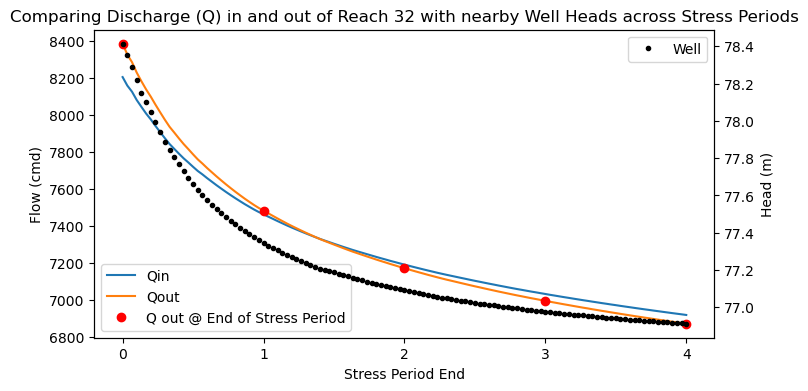

In [17]:
#Plotting out stream Q with head values across all time stepss
#modelname = "ScenarioSfr2500_Trans_1"
#np.loadtxt('TransSamples.txt').astype('int')
modelname = "ScenarioSfr1000SteadyPumpTest9_"+str(0)
sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
df = sfrout.get_dataframe()
rn =32
df.reset_index(drop = False, inplace = True) #FOr some reason the index seems to be off number wise so this helps
#display(df[df.reach == rn])

# Trying to figure out why the kstp and kper are all 0s - could just back the info out from the index number though
#times = sfrout.get_times() 
#df['kstpkper'] = times

#Backing out the stress period from the rows
#should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
df['Stp']= 1
df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*30*numtim)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column
#added *2 above for each computation step with kinematic wave routing

#group rows by change in Stp and grab the last Stress period 
Stpdf = df.groupby('Stp').tail(n=50) #groups tthe dataframe by the Stress period then grabs the last 50 rows (reaches) of the stress period representing the last timestep
#print(Stpdf.iloc[50])
#print(df.iloc[50])

inds = df.reach == 32 #grab indices for reach of interest
#print(df.reach[inds].astype(str))
#print(df.index)
ax = df.loc[inds, ["Qin","Qout"]].plot(figsize = (8,4))
ax.set_ylabel("Flow (cmd)")
ax.set_xlabel("Stress Period End");
ax.plot(Stpdf[Stpdf.reach == 32].index,Stpdf[Stpdf.reach == 32].Qout,'or', label = 'Q out @ End of Stress Period')
ax.legend(loc='lower left')
ticklabels = [0,1,2,3,4]
xticks = np.arange(0,7500,1500) + 31#[0,3031,6031,9031,12031]
ax.set_xticks(xticks)
ax.set_xticklabels(ticklabels)
ax.title.set_text('Comparing Discharge (Q) in and out of Reach 32 with nearby Well Heads across Stress Periods')
#Add the Stressperiod dataframe to the plot (checking to make sure it's all correct) - we lose the nice curves but this is much less data
#Stpdf.loc[inds, ["Qout", "Qin"]].plot(figsize = (20,7), ax = ax)


#modelname = "ScenarioSfr750Seasons_"+str(i)
headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#head = headobj.get_alldata(nodata=-9.9998999e+02)
head = headobj.get_ts([(0,23,32)]) #time series from obs well inbetween stream and pumping well
#print(head)
head[:,0] = ((head[:,0] - 10 ) / 6) * 50 *numtim +rn-1 #go from total time to the reach (50) period (6) times in the SFR file, times numtim (was 2, now 4)  if routing is on
#print(head)
ax2 = ax.twinx()
ax2.plot(head[:,0],head[:,1],'.k', label ='Well')
ax2.set_ylabel('Head (m)')
ax2.legend()

#print(df.loc[inds,["Qin","Qaquifer","Qout","Stp"]][df.Stp > 9])
Stpdf.reset_index(drop=True, inplace = True)
display(Stpdf)
lastStp = Stpdf.iloc[231]
print((lastStp.Qout / (lastStp.width * lastStp.depth) / 86400) *3.28, ' ft/s')

C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:609: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


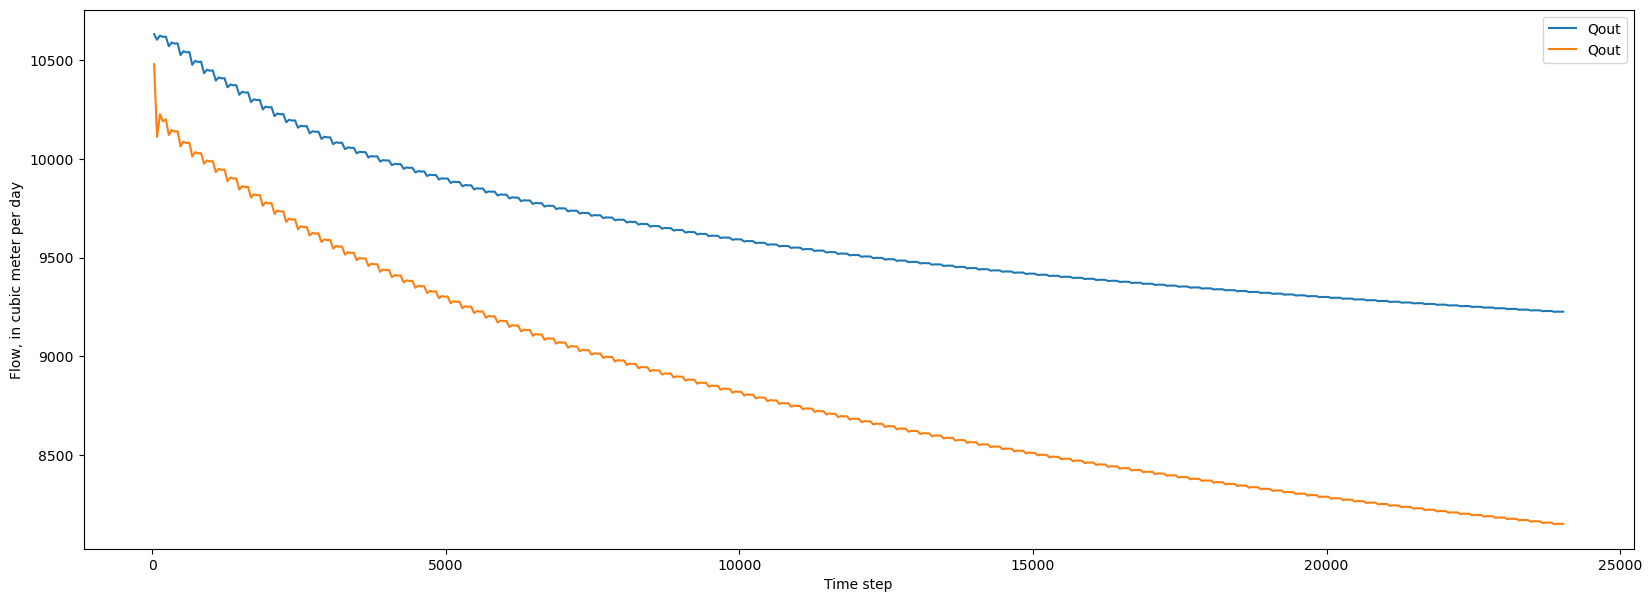

In [26]:
#Look at the variation in Q aquifer for the 5 random sampled simulations

for i in range(2):
    modelname = "ScenarioSfr1000SteadyPumpTest11_"+str(i)
    sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
    df = sfrout.get_dataframe()
    df.reset_index(drop = True, inplace = True)
     #grab indices for reach of interest
#print(df.reach[inds].astype(str))
    inds = df.reach == 32
    if i == 0:
        ax = df.loc[inds, ["Qout"]].plot(figsize = (20,7))
    else:
        df.loc[inds, ["Qout"]].plot(figsize = (20,7), ax =ax)
    
ax.set_ylabel("Flow, in cubic meter per day")
ax.set_xlabel("Time step");



(98., 71.5)


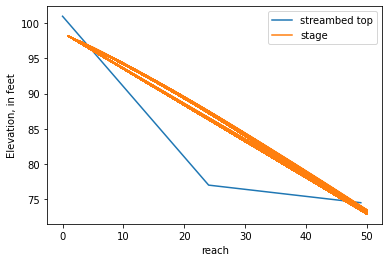

In [31]:
streambed_top = m.sfr.segment_data[0][m.sfr.segment_data[0].nseg == 1][["elevup", "elevdn"]][0]
print(streambed_top)


inds = df.segment == 1

fig, ax = plt.subplots()
plt.plot(np.arange(0,50), ztop[26], label="streambed top")
# ax = df.loc[inds, ['stage', 'model_top']].plot(ax=ax, x=df.reach[inds])
ax = df.loc[inds, ["reach", "stage"]].plot(ax=ax, x="reach")
ax.set_ylabel("Elevation, in feet")
plt.legend();

## Saving the output for each run 

In [145]:
#now in the bottom of the modflow run cell so no need to run this unless outside of that cell

error_list = np.loadtxt('ErrorSteadyPump_Sfr1000Test11.txt')
#print(error_list)
#sampling = np.loadtxt("ModflowParams7-750Test12.txt")
n = np.arange(0,len(sampling))
n = members
print(error_list[:,0])
n2 = np.setdiff1d(n, error_list[:,0].astype('int'))

for k,i in enumerate(n2):
    modelname = "ScenarioSfr1000SteadyPumpTest11_"+str(i)
    sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
    df = sfrout.get_dataframe()
    #Plot of all every reaches for every time step 
    #should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
    df['Stp']= 1
    df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*30*numtim)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column
    df['simnum'] = i
    #group rows by change in Stp and grab the last Stress period 
    Stpdf = df.groupby('Stp').tail(n=50) #groups tthe dataframe by the Stress period then grabs the last 50 rows (reaches) of the stress period representing the last timestep
    Stpdf.reset_index(drop=True, inplace = True)
   # print(Stpdf)
    if k == 0:
        savedf = Stpdf
    else:
        savedf = savedf.append(Stpdf) #apparently appending a dataframe is improper so this takes a minute

print(len(savedf))
savedf.to_csv('TransOutputStpSteadyPumpTest11.csv')

[ 26.  70.  86. 126. 296. 335. 343. 449. 519. 600. 605. 652. 660. 715.
 719. 893. 901. 936. 957.]
234500


In [5]:
#Test 
newdf = pd.read_csv('TransOutputStpSteadyPumpTest.csv')
print(newdf)

        Unnamed: 0  layer  row  column  segment  reach     Qin  Qaquifer  \
0                0      1   26       1        1      1   1.000    0.0000   
1                1      1   26       2        1      2   1.000  -10.8290   
2                2      1   26       3        1      3  11.829  -10.7070   
3                3      1   26       4        1      4  22.536  -10.8200   
4                4      1   26       5        1      5  33.356  -10.9370   
...            ...    ...  ...     ...      ...    ...     ...       ...   
148745         245      1   26      46        1     46  33.325    1.7999   
148746         246      1   26      47        1     47  31.642    1.7914   
148747         247      1   26      48        1     48  29.967    1.7823   
148748         248      1   26      49        1     49  28.304    1.7726   
148749         249      1   26      50        1     50  26.655    0.0000   

          Qout  Qovr  ...   depth  width    Cond  gradient  kstpkper  k   i  \
0       

## Read SFR outputs from Steady State notebook

In [208]:
#sfr_outfile = os.path.join(..', 'data', 'sfr_examples')
sfrout = SfrFile(modwsmodelname+'.sfr.out')
df = sfrout.get_dataframe()
print(df.Qaquifer[47])

-2.4791


C:\Users\davem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\davem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


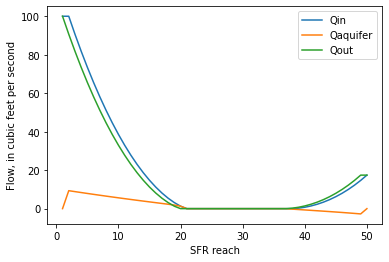

In [205]:
inds = df.segment == 1
#print(df.reach[inds].astype(str))
ax = df.loc[inds, ["reach", "Qin", "Qaquifer", "Qout"]].plot(x="reach")
ax.set_ylabel("Flow, in cubic feet per second")
ax.set_xlabel("SFR reach");

## Plots to make sure heads are okie dokie

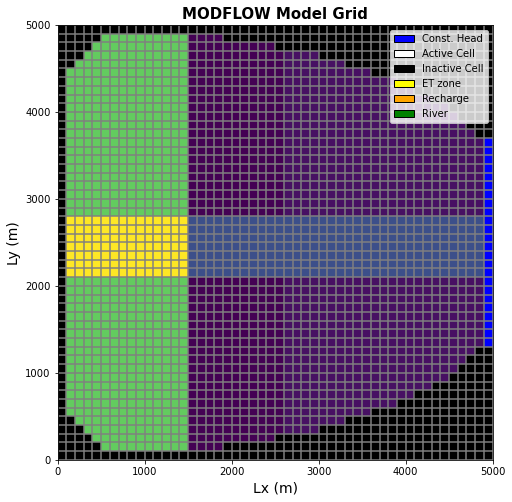

<Figure size 432x288 with 0 Axes>

In [59]:
#PLotting out the basin figure


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
# quadmesh = modelmap.plot_array(rech_zone_forced)
# quadmesh = modelmap.plot_array(Rip_zone)

#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
#riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc(ftype='RCH')
#quadmesh = modelmap.plot_array(win_sq_array)
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound(ibound)



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('MODFLOW Model Grid', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   # mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
plt.savefig('DomaingridNew.png')

C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\map.py:1272: DeprecationWarning: ModelMap is deprecated and has been replaced by PlotMapView(). ModelMap will be removed in version 3.3.5; Calling PlotMapView()
  warnings.warn(err_msg, DeprecationWarning)


AttributeError: 'NoneType' object has no attribute 'parent'

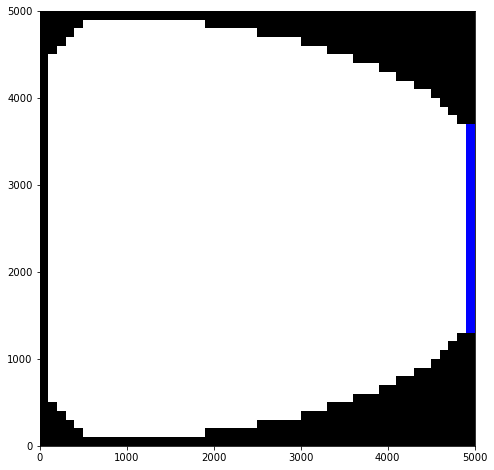

In [60]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
quadmesh = modelmap.plot_ibound()
riv_plot = modelmap.plot_bc('SFR')
#quadmesh = modelmap.plot_bc('WEL')
linecollection = modelmap.plot_grid()

[      nan       nan       nan       nan       nan 171.81361 171.16365
 170.06374 168.69116 167.04881 165.89494 164.2788  162.2466  159.8222
 157.01859 153.84712 150.89365 148.29123 146.41052       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan]


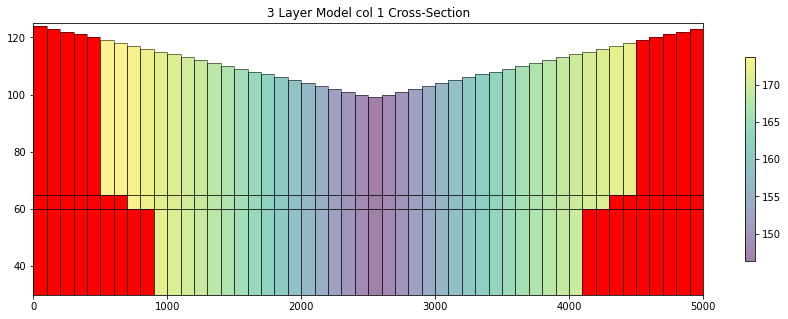

In [71]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 1}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 1 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

print(head[0][0][1][:])